In [1]:
import torch
import models.p2pnet
import numpy
import os
import argparse
import random
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import DataLoader

from tsnecuda import TSNE
from sklearn.decomposition import PCA

from crowd_datasets import build_dataset
from engine import *
from models import build_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# load in models and dataset
result_dir = "results/updateset_highres_emb_FPN1_r1_c1_512ps/" 
model_dir =  "weights/best_mae.pth"
data_dir = "dataroot/updated_all_images"

# load in the arugments from the result di 
def load_args(filepath):
    with open(filepath, 'r') as f:
        namespace_str = f.read().strip()
    
    # Remove "Namespace(" from beginning and ")" from end
    params_str = namespace_str[10:-1]
    
    # Parse the parameters into a dictionary
    params = {}
    for param in params_str.split(','):
        if '=' in param:
            key, value = param.split('=', 1)
            key = key.strip()
            value = value.strip()
            # Handle different value types
            if value.lower() == 'true':
                value = True
            elif value.lower() == 'false':
                value = False
            elif value.lower() == 'none':
                value = None
            else:
                try:
                    value = float(value) if '.' in value else int(value)
                except ValueError:
                    # If not a number, remove quotes if present
                    value = value.strip("'\"")
                    # make list if brakets are present
                    if '[' in value: value = list(value)

            params[key] = value
    
    return argparse.Namespace(**params)

args = load_args(os.path.join(result_dir, "args.txt"))

# hard code some args
args.loss = ['labels', 'points']
args.multiclass = ['embryo']
args.ce_coef = [1.0]
args.dataset_file = "WORM_VAL"
args.gpu_id = 1

print(args) 

# load in model
model = build_model(args)
checkpoint = torch.load(os.path.join(result_dir, model_dir), map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval()


# import dataset
loading_data = build_dataset(args)

train_set, val_set = loading_data(
    data_dir,
    multiclass=args.multiclass,
    hsv=args.hsv,
    hse=args.hse,
    edges=args.edges,
    equalize=args.equalize,
)
# create the sampler used during training
sampler_val = torch.utils.data.SequentialSampler(val_set)

 
data_loader_val = DataLoader(
    val_set,
    1,
    sampler=sampler_val,
    drop_last=False,
    collate_fn=utils.collate_fn_crowd,
    num_workers=args.num_workers,
)

FileNotFoundError: [Errno 2] No such file or directory: 'results/updateset_highres_emb_FPN1_r1_c1_512ps/args.txt'

: 

In [ ]:
# run outputs 
conv_out = {}
def set_hook(name):
    def hook(model, input, output):
        conv_out[name] = output.detach()
    return hook


model.classification.conv1.register_forward_hook(set_hook("class_conv_1"))
model.classification.conv2.register_forward_hook(set_hook("class_conv_2"))
model.classification.output.register_forward_hook(set_hook("class_out"))
model.regression.conv1.register_forward_hook(set_hook("reg_conv_1"))
model.regression.conv2.register_forward_hook(set_hook("reg_conv_2"))
model.regression.output.register_forward_hook(set_hook("reg_out"))

X,Y = next(iter(data_loader_val))
X = X.to(device)
output = model(X)

: 

: 

In [ ]:
model

P2PNet(
  (backbone): Backbone_VGG(
    (body1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
    )
    (body2): Sequential(
      (0): MaxPool2d(ke

: 

: 

In [ ]:
X.size()

torch.Size([1, 3, 4096, 4608])

: 

: 

In [ ]:
# classify each point
pred_logits = output['pred_logits']
pred_points = output['pred_points']
pred_logits.size()

torch.Size([1, 1179648, 2])

: 

: 

In [ ]:
print(conv_out['class_out'])

tensor([[[[ 1.6325,  2.5645,  2.5595,  ...,  2.6399,  2.4398,  1.5642],
          [ 2.5149,  4.0178,  4.0167,  ...,  4.2253,  3.9539,  2.6499],
          [ 2.5361,  4.0699,  4.1158,  ...,  4.6446,  4.4648,  3.0437],
          ...,
          [ 3.1500,  5.3425,  5.8998,  ...,  5.1434,  4.7929,  3.0939],
          [ 2.9608,  5.0197,  5.5129,  ...,  4.4909,  4.3031,  2.8552],
          [ 1.9781,  3.3455,  3.6886,  ...,  2.7547,  2.7738,  1.9460]],

         [[-1.7480, -2.7145, -2.6643,  ..., -2.7058, -2.5034, -1.6976],
          [-2.7185, -4.0741, -4.0109,  ..., -4.2315, -3.9543, -2.5897],
          [-2.7423, -4.0800, -4.0567,  ..., -4.6175, -4.4036, -2.8678],
          ...,
          [-3.3937, -5.4200, -5.8699,  ..., -5.1399, -4.7049, -2.9453],
          [-3.3293, -5.3096, -5.6787,  ..., -4.5820, -4.3400, -2.7569],
          [-2.3203, -3.5654, -3.7801,  ..., -2.8560, -2.7594, -1.7384]],

         [[ 2.2576,  3.3406,  3.0470,  ...,  2.9539,  2.7336,  1.9303],
          [ 3.5696,  5.1105,  

: 

: 

In [ ]:
embedding = conv_out['class_out']
print(embedding.size())
# reshape embedding to appropriate size
embedding = embedding.squeeze(0)
embedding = embedding.view(-1, embedding.size(1) * embedding.size(2))
print(embedding.size())
embedding = embedding.permute(1,0)
embedding = embedding.cpu().numpy()

torch.Size([1, 256, 512, 576])
torch.Size([256, 294912])


: 

: 

In [ ]:
embedding.shape

(294912, 256)

: 

: 

In [ ]:
embedding_tsne = TSNE().fit_transform(embedding)
embedding_tsne.shape

(294912, 2)

: 

: 

/tmp/ipykernel_523690/2975369827.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

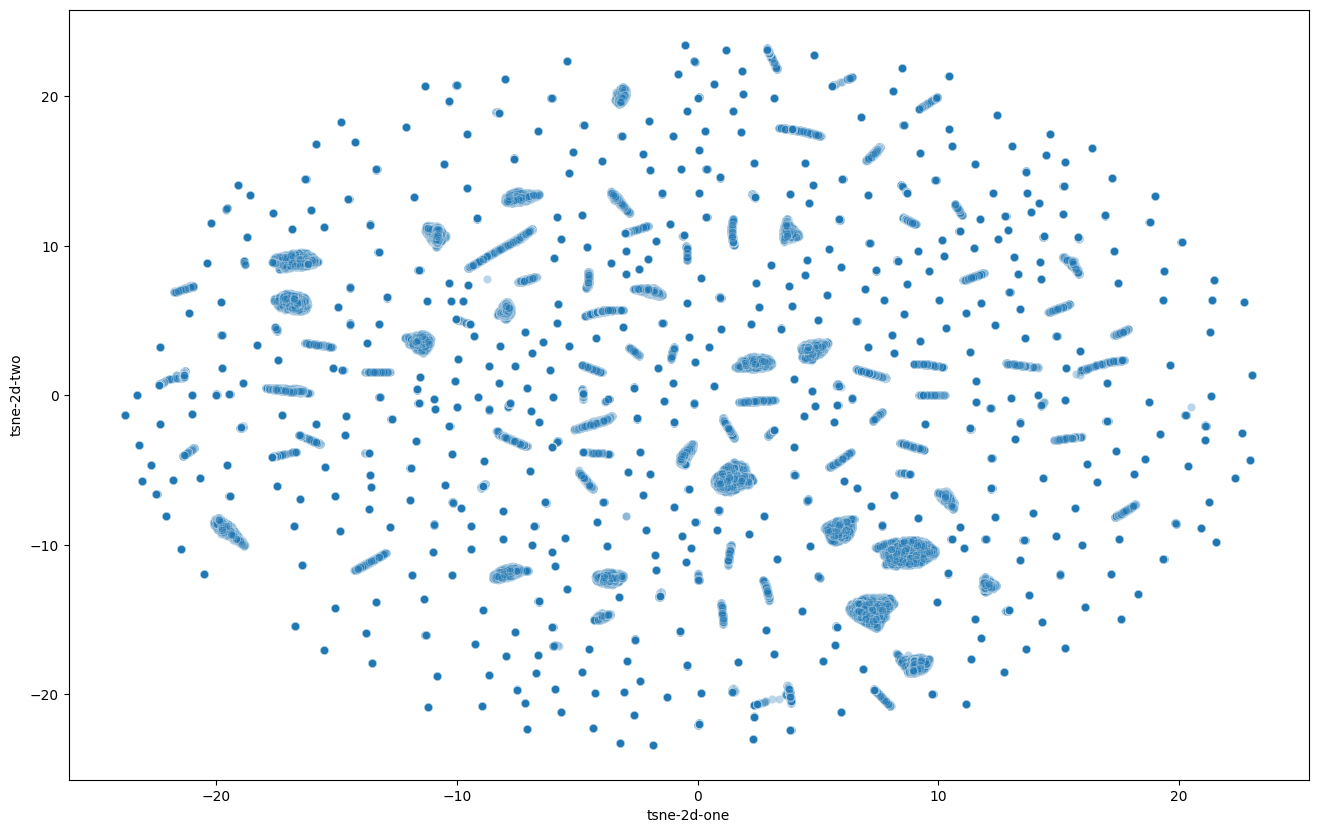

: 

: 

In [ ]:
tsne_df = pd.DataFrame(data=embedding_tsne, columns=['tsne-2d-one', 'tsne-2d-two'] )

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.3
)